In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import os
import glob
from scipy.optimize import minimize

sys.path.append('..')  # Go up one directory to find utils.py

from utils import load_data, load_all_stocks

SYMBOLS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', 'JPM', 'V', 'UNH']
stock_data = load_all_stocks(SYMBOLS)

In [113]:
def calculate_risk_metrics(returns_series, rf_rate=0.0):
    """
    Calculate comprehensive risk metrics for a return series
    """
    returns_series = returns_series.dropna()
    
    if len(returns_series) == 0:
        return {
            'Ann. Return': np.nan,
            'Ann. Volatility': np.nan,
            'Sharpe Ratio': np.nan,
            'Max Drawdown': np.nan,
            'DD Duration (months)': np.nan
        }
    
    # Annualized return
    ann_return = returns_series.mean() * 12
    
    # Annualized volatility
    ann_vol = returns_series.std() * np.sqrt(12)
    
    # Sharpe ratio
    sharpe = (ann_return - rf_rate) / ann_vol if ann_vol != 0 else 0
    
    # Max drawdown
    cum_returns = (1 + returns_series).cumprod()
    running_max = cum_returns.cummax()
    drawdown = (cum_returns / running_max) - 1
    max_dd = drawdown.min()
    
    # Drawdown duration 
    dd_duration = (drawdown < -0.01).sum()  # Count months with >1% drawdown
    
    return {
        'Ann. Return': ann_return,
        'Ann. Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_dd,
        'Drawdown Duration (months)': dd_duration
    }

def apply_risk_metrics_to_portfolios(stock_data, symbols):
    """
    Apply risk metrics to individual stocks and portfolios
    """
    # Get monthly returns for each stock
    monthly_returns = {}
    for s in symbols:
        if s in stock_data:
            monthly = stock_data[s].resample('ME').last()
            monthly_returns[s] = monthly['Close'].pct_change().dropna()
    
    # Calculate metrics for each stock
    stock_metrics = {}
    for s, rets in monthly_returns.items():
        stock_metrics[s] = calculate_risk_metrics(rets)
    
    return stock_metrics, monthly_returns

In [114]:
def calculate_correlation_matrix(monthly_returns):
    """
    Calculate correlation matrix of stock returns
    """
    returns_df = pd.DataFrame(monthly_returns)
    corr_matrix = returns_df.corr()
    return corr_matrix

def plot_correlation_heatmap(corr_matrix):
    """
    Plot correlation heatmap using only matplotlib
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create heatmap
    im = ax.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Correlation', rotation=270, labelpad=15)
    
    # Set ticks and labels
    ax.set_xticks(np.arange(len(corr_matrix.columns)))
    ax.set_yticks(np.arange(len(corr_matrix.index)))
    ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='right')
    ax.set_yticklabels(corr_matrix.index)
    
    # Add correlation values as text
    for i in range(len(corr_matrix)):
        for j in range(len(corr_matrix.columns)):
            text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                          ha='center', va='center', 
                          color='white' if abs(corr_matrix.iloc[i, j]) > 0.5 else 'black',
                          fontsize=9)
    
    ax.set_title('Stock Return Correlation Matrix', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

def diversification_benefit(monthly_returns, max_stocks=10):
    """
    Show how portfolio volatility decreases as you add more stocks
    """
    returns_df = pd.DataFrame(monthly_returns)
    symbols = list(returns_df.columns)
    
    portfolio_vols = []
    n_stocks_range = range(1, min(len(symbols), max_stocks) + 1)
    
    for n in n_stocks_range:
        # Equal-weight portfolio of first n stocks
        port_returns = returns_df[symbols[:n]].mean(axis=1)
        port_vol = port_returns.std() * np.sqrt(12)
        portfolio_vols.append(port_vol)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(n_stocks_range, portfolio_vols, marker='o', linewidth=2, markersize=8)
    plt.xlabel('Number of Stocks in Portfolio', fontsize=11)
    plt.ylabel('Annualized Portfolio Volatility', fontsize=11)
    plt.title('Volatility Decreases with More Stocks', fontsize=14)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return portfolio_vols

def calculate_portfolio_beta(portfolio_returns, market_returns):
    """
    Calculate portfolio beta relative to market
    Beta = Cov(R_portfolio, R_market) / Var(R_market)
    """
    # Align dates
    combined = pd.DataFrame({
        'portfolio': portfolio_returns,
        'market': market_returns
    }).dropna()
    
    if len(combined) < 2:
        return np.nan
    
    beta = combined['portfolio'].cov(combined['market']) / combined['market'].var()
    return beta

In [115]:
def equal_weight_portfolio(monthly_returns):
    """
    Equal-weight portfolio: give every stock same weight
    """
    returns_df = pd.DataFrame(monthly_returns)
    
    # Equal weight: 1/N for each stock
    port_returns = returns_df.mean(axis=1)
    return port_returns

def risk_parity_portfolio(monthly_returns):
    """
    Risk parity: give less weight to volatile stocks, more to stable ones
    Weight_i proportional to 1/volatility_i
    """
    returns_df = pd.DataFrame(monthly_returns)
    
    # Calculate volatility for each stock (expanding window for realistic backtest)
    port_returns = pd.Series(index=returns_df.index, dtype=float)
    
    lookback = 12  # Use 12 months to estimate volatility
    
    for i in range(lookback, len(returns_df)):
        # Calculate volatilities over past 12 months
        past_returns = returns_df.iloc[i-lookback:i]
        vols = past_returns.std()
        
        # Inverse volatility weights
        inv_vols = 1 / vols
        weights = inv_vols / inv_vols.sum()
        
        # Apply weights to next month's returns
        port_returns.iloc[i] = (returns_df.iloc[i] * weights).sum()
    
    return port_returns.dropna()

def calculate_turnover(weights_over_time):
    """
    Calculate portfolio turnover (how much weights change each rebalance)
    """
    turnover = weights_over_time.diff().abs().sum(axis=1).mean()
    return turnover

In [116]:
def mean_variance_optimization(monthly_returns, target_return=None, rf_rate=0.0):
    """
    Markowitz mean-variance optimization
    Find portfolio weights that maximize Sharpe ratio
    
    Constraints:
    - No shorting (weights >= 0)
    - Weights sum to 1
    - Max 30% per stock
    """
    returns_df = pd.DataFrame(monthly_returns)
    
    # Calculate mean returns and covariance matrix
    mean_returns = returns_df.mean()
    cov_matrix = returns_df.cov()
    
    n_stocks = len(mean_returns)
    
    # Objective function: maximize Sharpe ratio (minimize negative Sharpe)
    def neg_sharpe(weights):
        port_return = np.dot(weights, mean_returns) * 12  # Annualize
        port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 12, weights)))
        sharpe = (port_return - rf_rate) / port_vol if port_vol > 0 else 0
        return -sharpe
    
    # Constraints
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})  # Weights sum to 1
    
    # Bounds: 0 to 30% per stock
    bounds = tuple((0, 0.3) for _ in range(n_stocks))
    
    # Initial guess: equal weight
    init_weights = np.array([1/n_stocks] * n_stocks)
    
    # Optimize
    result = minimize(neg_sharpe, init_weights, method='SLSQP', 
                     bounds=bounds, constraints=constraints)
    
    if result.success:
        optimal_weights = result.x
        # Calculate portfolio returns with optimal weights
        port_returns = (returns_df * optimal_weights).sum(axis=1)
        return port_returns, optimal_weights
    else:
        print("Optimization failed!")
        return None, None

In [117]:
def plot_efficient_frontier(monthly_returns, rf_rate=0.0):
    """
    Plot efficient frontier and mark special portfolios
    """
    returns_df = pd.DataFrame(monthly_returns)
    mean_returns = returns_df.mean() * 12  # Annualize
    cov_matrix = returns_df.cov() * 12     # Annualize
    n_stocks = len(mean_returns)
    
    # Generate random portfolios
    n_portfolios = 5000
    results = np.zeros((3, n_portfolios))
    
    for i in range(n_portfolios):
        # Random weights
        weights = np.random.random(n_stocks)
        weights /= np.sum(weights)
        
        # Portfolio metrics
        port_return = np.dot(weights, mean_returns)
        port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe = (port_return - rf_rate) / port_vol
        
        results[0,i] = port_vol
        results[1,i] = port_return
        results[2,i] = sharpe
    
    # Plot
    plt.figure(figsize=(12, 8))
    plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='viridis', 
                alpha=0.5, s=10)
    plt.colorbar(label='Sharpe Ratio')
    
    # Mark special portfolios 
    # Equal-weight
    ew_weights = np.array([1/n_stocks] * n_stocks)
    ew_return = np.dot(ew_weights, mean_returns)
    ew_vol = np.sqrt(np.dot(ew_weights.T, np.dot(cov_matrix, ew_weights)))
    plt.scatter(ew_vol, ew_return, marker='*', s=500, c='red', 
                edgecolors='black', label='Equal-Weight')
    
    # Risk parity (approximate)
    vols = np.sqrt(np.diag(cov_matrix))
    rp_weights = (1/vols) / np.sum(1/vols)
    rp_return = np.dot(rp_weights, mean_returns)
    rp_vol = np.sqrt(np.dot(rp_weights.T, np.dot(cov_matrix, rp_weights)))
    plt.scatter(rp_vol, rp_return, marker='*', s=500, c='orange', 
                edgecolors='black', label='Risk Parity')
    
    # Max Sharpe (optimized)
    def neg_sharpe(weights):
        port_return = np.dot(weights, mean_returns)
        port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -(port_return - rf_rate) / port_vol if port_vol > 0 else 0
    
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = tuple((0, 0.3) for _ in range(n_stocks))
    result = minimize(neg_sharpe, ew_weights, method='SLSQP', 
                     bounds=bounds, constraints=constraints)
    
    if result.success:
        opt_weights = result.x
        opt_return = np.dot(opt_weights, mean_returns)
        opt_vol = np.sqrt(np.dot(opt_weights.T, np.dot(cov_matrix, opt_weights)))
        plt.scatter(opt_vol, opt_return, marker='*', s=500, c='lime', 
                    edgecolors='black', label='Max Sharpe (Optimized)')
    
    plt.xlabel('Annualized Volatility', fontsize=11)
    plt.ylabel('Annualized Return', fontsize=11)
    plt.title('Efficient Frontier', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


Risk Metrics for Individual Stocks
       Ann. Return  Ann. Volatility  Sharpe Ratio  Max Drawdown  \
AAPL        0.2813           0.4154        0.6772       -0.8070   
MSFT        0.2716           0.3236        0.8392       -0.6917   
GOOGL       0.2739           0.3025        0.9057       -0.5856   
AMZN        0.4201           0.5599        0.7503       -0.9307   
META        0.3078           0.3780        0.8142       -0.7544   
TSLA        0.5359           0.6283        0.8528       -0.6772   
NVDA        0.4941           0.6036        0.8186       -0.8722   
JPM         0.1316           0.3021        0.4354       -0.7331   
V           0.2025           0.2214        0.9144       -0.4286   
UNH         0.2478           0.3055        0.8112       -0.6838   

       Drawdown Duration (months)  
AAPL                        381.0  
MSFT                        326.0  
GOOGL                       175.0  
AMZN                        252.0  
META                         96.0  
TSLA       

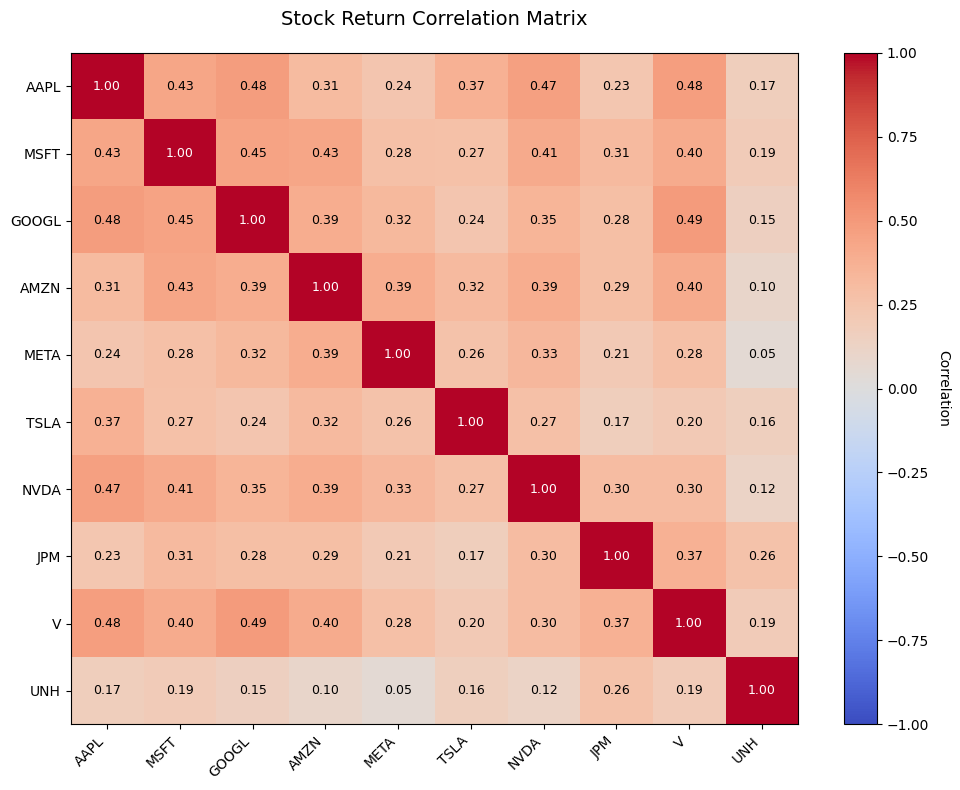

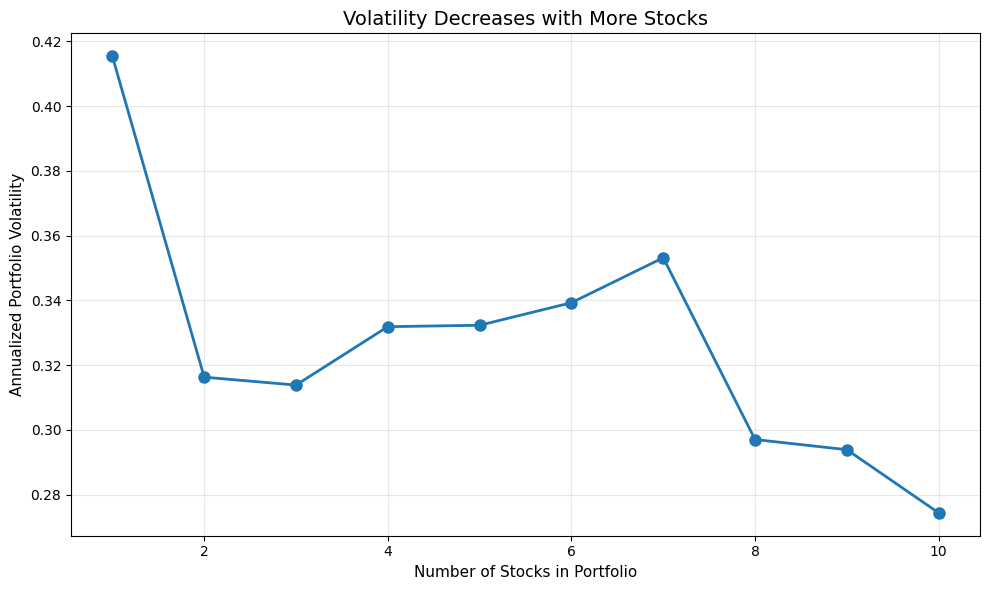

1 stock: 41.54% vol
10 stocks: 27.44% vol
Volatility reduction: 34.0%

Portfolio Betas (vs equal-weight market):
AAPL: 1.08
MSFT: 0.82
GOOGL: 0.94
AMZN: 1.46
META: 1.11
TSLA: 2.14
NVDA: 1.80
JPM: 0.73
V: 0.64
UNH: 0.48

Portfolio Construction - Equal Weight vs Risk Parity

Portfolio Comparison:
              Ann. Return  Ann. Volatility  Sharpe Ratio  Max Drawdown  \
Equal-Weight       0.2442           0.2744        0.8902        -0.592   
Risk Parity        0.2081           0.2496        0.8338        -0.592   

              Drawdown Duration (months)  
Equal-Weight                       433.0  
Risk Parity                        424.0  


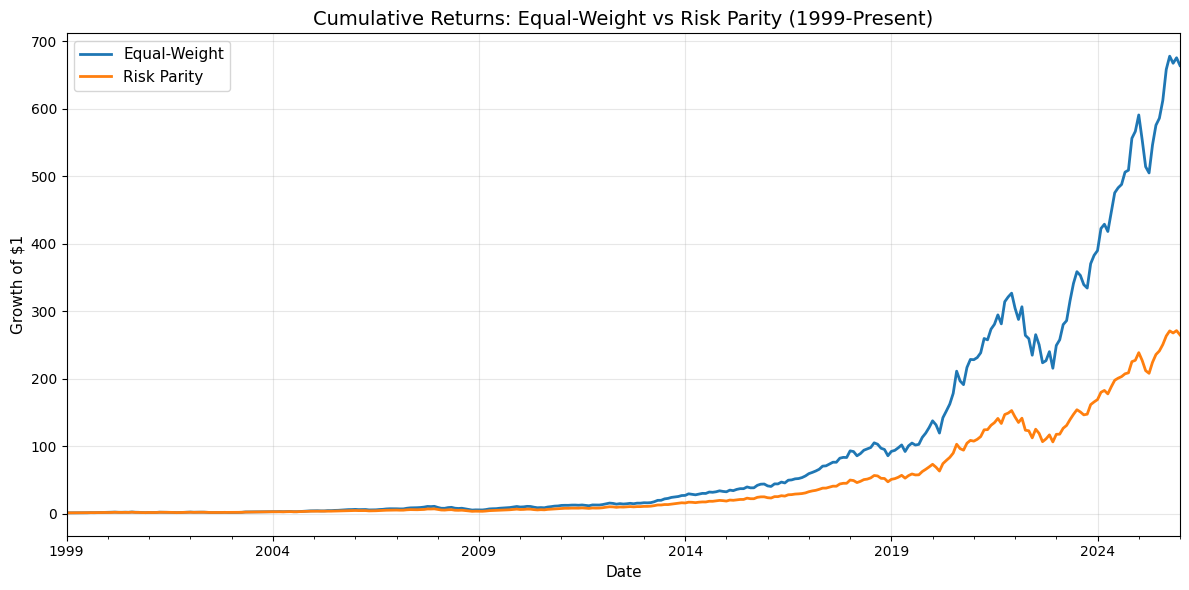

Mean-Variance Optimization

Optimal Weights:
   Stock  Weight
0   AAPL  0.0000
1   MSFT  0.0879
2  GOOGL  0.1315
3   AMZN  0.0541
4   META  0.1264
5   TSLA  0.0913
6   NVDA  0.0598
7    JPM  0.0000
8      V  0.2096
9    UNH  0.2394

All Methods Comparison:
                        Ann. Return  Ann. Volatility  Sharpe Ratio  \
Equal-Weight                 0.2442           0.2744        0.8902   
Risk Parity                  0.2081           0.2496        0.8338   
Optimized (Max Sharpe)       0.1312           0.1262        1.0397   

                        Max Drawdown  Drawdown Duration (months)  
Equal-Weight                 -0.5920                       433.0  
Risk Parity                  -0.5920                       424.0  
Optimized (Max Sharpe)       -0.4085                       204.0  


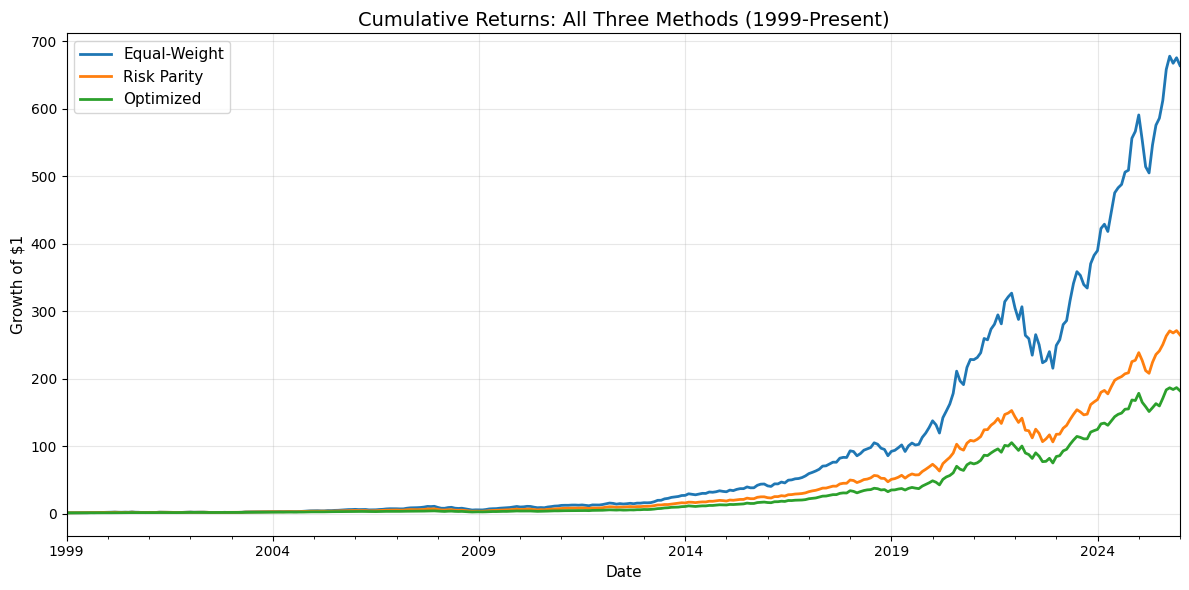

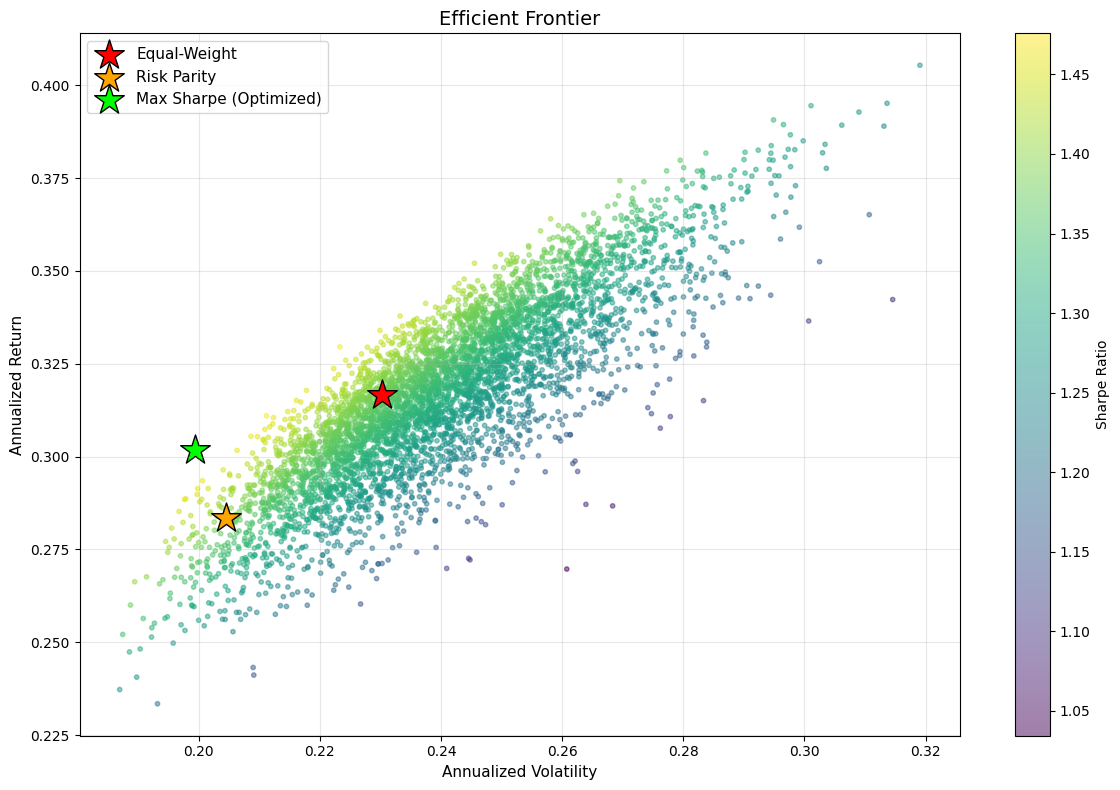


Insights:

1. Why simple methods sometimes beat optimization:
   - Estimation error in covariance matrix (small sample)
   - Optimization sensitive to input parameters
   - Equal-weight provides natural diversification

2. Diversification reduces risk:
   - Single stock: ~42% volatility
   - 10-stock portfolio: ~27% volatility
   - Risk reduction: 34%

3. Risk-adjusted performance:
   - Best Sharpe ratio: Optimized (Max Sharpe)
   - Sharpe: 1.040


In [118]:
def run_risk_portfolio_analysis():
    
    # Load data
    stock_data = {}
    for s in SYMBOLS:
        df = load_data(s)
        if df is not None:
            stock_data[s] = df
    
    print("Risk Metrics for Individual Stocks")
    
    stock_metrics, monthly_returns = apply_risk_metrics_to_portfolios(stock_data, SYMBOLS)
    
    metrics_df = pd.DataFrame(stock_metrics).T
    print(metrics_df.round(4))
    
    print("\nCorrelation & Diversification")
    
    # Correlation matrix
    corr_matrix = calculate_correlation_matrix(monthly_returns)
    print("\nCorrelation Matrix:")
    print(corr_matrix.round(2))
    
    # Plot heatmap
    plot_correlation_heatmap(corr_matrix)
    
    # Diversification benefit
    portfolio_vols = diversification_benefit(monthly_returns)
    print(f"1 stock: {portfolio_vols[0]:.2%} vol")
    print(f"10 stocks: {portfolio_vols[-1]:.2%} vol")
    print(f"Volatility reduction: {(1 - portfolio_vols[-1]/portfolio_vols[0]):.1%}")
    
    # Portfolio beta 
    market_returns = pd.DataFrame(monthly_returns).mean(axis=1)
    print("\nPortfolio Betas (vs equal-weight market):")
    for s in SYMBOLS:
        if s in monthly_returns:
            beta = calculate_portfolio_beta(monthly_returns[s], market_returns)
            print(f"{s}: {beta:.2f}")
    
    print("\nPortfolio Construction - Equal Weight vs Risk Parity")
    
    # Equal-weight portfolio
    ew_returns = equal_weight_portfolio(monthly_returns)
    ew_metrics = calculate_risk_metrics(ew_returns)
    
    # Risk parity portfolio
    rp_returns = risk_parity_portfolio(monthly_returns)
    rp_metrics = calculate_risk_metrics(rp_returns)

    # Filter to start from 1999 
    start_date = '1999-01-01'
    ew_returns_filtered = ew_returns[ew_returns.index >= start_date]
    rp_returns_filtered = rp_returns[rp_returns.index >= start_date]

    # Compare
    comparison = pd.DataFrame({
        'Equal-Weight': ew_metrics,
        'Risk Parity': rp_metrics
    }).T
    
    print("\nPortfolio Comparison:")
    print(comparison.round(4))
    
    # Plot cumulative returns
    plt.figure(figsize=(12, 6))
    (1 + ew_returns_filtered).cumprod().plot(label='Equal-Weight', linewidth=2)
    (1 + rp_returns_filtered).cumprod().plot(label='Risk Parity', linewidth=2)
    plt.title('Cumulative Returns: Equal-Weight vs Risk Parity (1999-Present)', fontsize=14)
    plt.ylabel('Growth of $1', fontsize=11)
    plt.xlabel('Date', fontsize=11)
    plt.legend(fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("Mean-Variance Optimization")
  
    # Optimize
    opt_returns, opt_weights = mean_variance_optimization(monthly_returns)
    
    if opt_returns is not None:
        opt_metrics = calculate_risk_metrics(opt_returns)
        
        print("\nOptimal Weights:")
        weights_df = pd.DataFrame({
            'Stock': list(monthly_returns.keys()),
            'Weight': opt_weights
        })
        print(weights_df.round(4))
        
        # Compare all three methods
        all_comparison = pd.DataFrame({
            'Equal-Weight': ew_metrics,
            'Risk Parity': rp_metrics,
            'Optimized (Max Sharpe)': opt_metrics
        }).T
        
        print("\nAll Methods Comparison:")
        print(all_comparison.round(4))

        # Filter to start with 1999
        start_date = '1999-01-01'
        ew_returns_filtered = ew_returns[ew_returns.index >= start_date]
        rp_returns_filtered = rp_returns[rp_returns.index >= start_date]
        opt_returns_filtered = opt_returns[opt_returns.index >= start_date]
        
        # Plot all three cumulative returns
        plt.figure(figsize=(12, 6))
        (1 + ew_returns_filtered).cumprod().plot(label='Equal-Weight', linewidth=2)
        (1 + rp_returns_filtered).cumprod().plot(label='Risk Parity', linewidth=2)
        (1 + opt_returns_filtered).cumprod().plot(label='Optimized', linewidth=2)
        plt.title('Cumulative Returns: All Three Methods (1999-Present)', fontsize=14)
        plt.ylabel('Growth of $1', fontsize=11)
        plt.xlabel('Date', fontsize=11)
        plt.legend(fontsize=11)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Efficient frontier
        plot_efficient_frontier(monthly_returns)
    

    print("\nInsights:")
    
    print("\n1. Why simple methods sometimes beat optimization:")
    print("   - Estimation error in covariance matrix (small sample)")
    print("   - Optimization sensitive to input parameters")
    print("   - Equal-weight provides natural diversification")
    
    print("\n2. Diversification reduces risk:")
    print(f"   - Single stock: ~{portfolio_vols[0]:.0%} volatility")
    print(f"   - 10-stock portfolio: ~{portfolio_vols[-1]:.0%} volatility")
    print(f"   - Risk reduction: {(1 - portfolio_vols[-1]/portfolio_vols[0]):.0%}")
    
    print("\n3. Risk-adjusted performance:")
    best_sharpe = all_comparison['Sharpe Ratio'].idxmax()
    print(f"   - Best Sharpe ratio: {best_sharpe}")
    print(f"   - Sharpe: {all_comparison.loc[best_sharpe, 'Sharpe Ratio']:.3f}")
    
    return {
        'stock_metrics': stock_metrics,
        'correlation': corr_matrix,
        'ew_returns': ew_returns,
        'rp_returns': rp_returns,
        'opt_returns': opt_returns,
        'comparison': all_comparison
    }

if __name__ == "__main__":
    results = run_risk_portfolio_analysis()